In [1]:
!pip install implicit optuna rectools cupy-cuda12x > None

In [2]:
!apt-get install nvidia-cuda-toolkit > None

Extracting templates from packages: 100%


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import cupy

cupy.is_available()

True

In [3]:
import gc
import os
import random
import zipfile as zf
from copy import deepcopy
from functools import partial
from typing import Any, Dict, Sequence

import numpy as np
import optuna
import pandas as pd
import requests
from implicit.gpu.als import AlternatingLeastSquares
from optuna.samplers import TPESampler
from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import Recall, calc_metrics
from rectools.metrics.base import MetricAtK
from rectools.models import ImplicitALSWrapperModel, PopularModel
from tqdm import tqdm

In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [5]:
TOP_N_CANDIDATES=100
RANKER_DAYS_COUNT = 30
K_RECOS=10

## Подготовка датасета

Загрузим датасет

In [6]:
url = "https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip"

In [7]:
req = requests.get(url, stream=True)

with open("kion.zip", "wb") as fd:
    total_size_in_bytes = int(req.headers.get("Content-Length", 0))
    progress_bar = tqdm(desc="kion dataset download", total=total_size_in_bytes, unit="iB", unit_scale=True)
    for chunk in req.iter_content(chunk_size=2**20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:  90%|█████████ | 71.3M/78.8M [00:00<00:00, 140MiB/s] 

In [8]:
files = zf.ZipFile("kion.zip", "r")
files.extractall()
files.close()

In [9]:
interactions_df = pd.read_csv("data_original/interactions.csv")

In [10]:
users = pd.read_csv("data_original/users.csv")
items = pd.read_csv("data_original/items.csv")

In [11]:
Columns.Datetime = "last_watch_dt"
interactions_df.drop(interactions_df[interactions_df[Columns.Datetime].str.len() != 10].index, inplace=True)
interactions_df[Columns.Datetime] = pd.to_datetime(interactions_df[Columns.Datetime], format="%Y-%m-%d")
interactions_df[Columns.Weight] = np.where(interactions_df["watched_pct"] > 10, 3, 1)

kion dataset download: 100%|██████████| 78.8M/78.8M [00:11<00:00, 140MiB/s]

В семинаре была схема валидации. В соответствии с ней, давайте сразу разобьем данные на train моделей первого уровня и все остальное

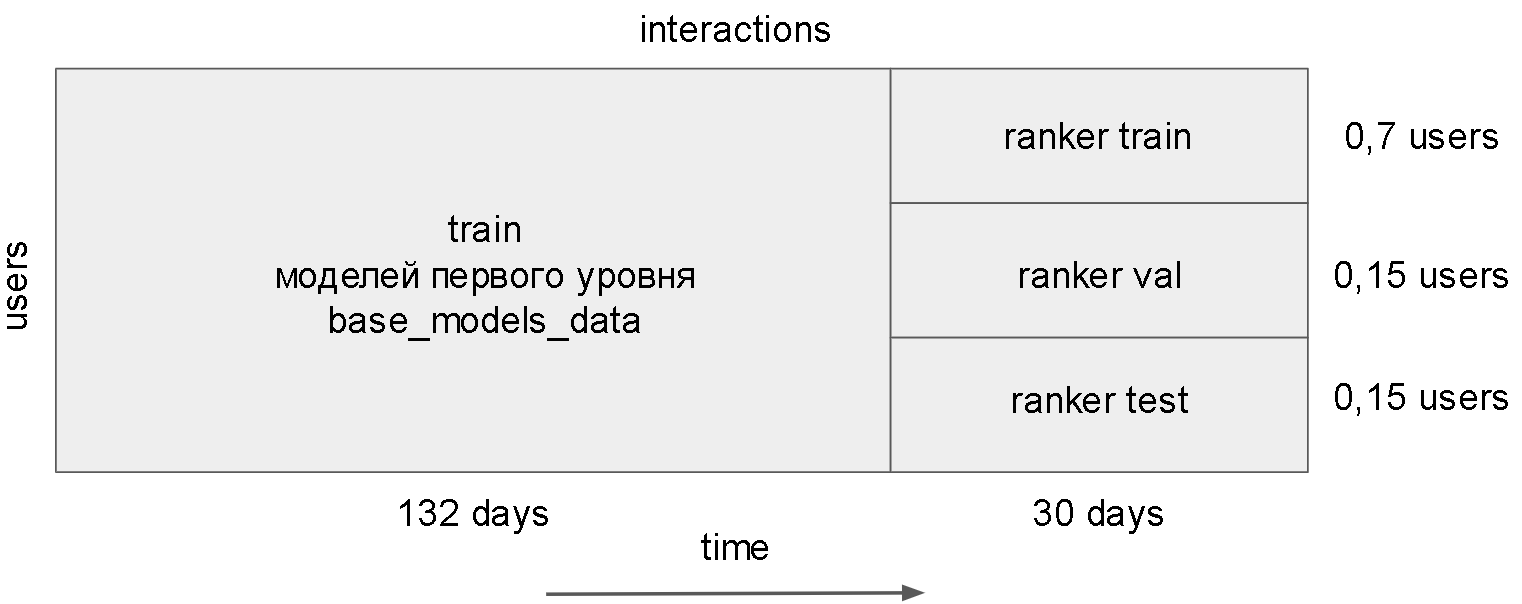

Все, что находится дальше предыдущих 30 дней, отбираем для моделей первого уровня

In [12]:
max_date = interactions_df[Columns.Datetime].max()
base_models_data = interactions_df[
    (interactions_df[Columns.Datetime] < max_date - pd.Timedelta(days=RANKER_DAYS_COUNT))
]

In [13]:
base_models_data.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,3
1,699317,1659,2021-05-29,8317,100.0,3
2,656683,7107,2021-05-09,10,0.0,1
3,864613,7638,2021-07-05,14483,100.0,3
4,964868,9506,2021-04-30,6725,100.0,3


Для моделей первого уровня важно, чтобы она максимизировала recall. Давайте подберем такие параметры модели, чтобы она это собственно делала. Но сначала надо датасет на train и test разделить

In [61]:
max_date_base_model = base_models_data[Columns.Datetime].max()
train = base_models_data[base_models_data[Columns.Datetime] < max_date_base_model - pd.Timedelta(days=7)].copy()
test = base_models_data[base_models_data[Columns.Datetime] >= max_date_base_model - pd.Timedelta(days=7)].copy()

In [62]:
train.drop(train.query("total_dur < 300").index, inplace=True)
cold_users = set(test[Columns.User]) - set(train[Columns.User])
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

Отбираем фичи в датасете

In [14]:
def get_users_features(users: pd.DataFrame, interactions: pd.DataFrame, features: Sequence[str]) -> pd.DataFrame:
    users.fillna("Unknown", inplace=True)
    users = users.loc[users[Columns.User].isin(interactions[Columns.User])].copy()
    user_features_frames = []
    for feature in features:
        feature_frame = users.reindex(columns=[Columns.User, feature])
        feature_frame.columns = ["id", "value"]
        feature_frame["feature"] = feature
        user_features_frames.append(feature_frame)
    user_features = pd.concat(user_features_frames)
    return user_features

In [64]:
features = ["sex", "age", "income"]
user_features = get_users_features(users=users, interactions=train, features=features)

In [15]:
def get_items_features(items: pd.DataFrame, interactions: pd.DataFrame, features: Sequence[str]) -> pd.DataFrame:
    items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()
    items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
    item_features_frames = []
    for feature in features:
        feature_frame = items[["item_id", feature]].explode(feature)
        feature_frame.columns = ["id", "value"]
        feature_frame["feature"] = feature
        content_feature = items.reindex(columns=[Columns.Item, "content_type"])
        content_feature.columns = ["id", "value"]
        content_feature["feature"] = "content_type"
        item_features_frames.append(pd.concat((feature_frame, content_feature)))
    item_features = pd.concat(item_features_frames)
    return item_features

In [66]:
features = ["genre"]
item_features = get_items_features(items=items, interactions=train, features=features)

In [67]:
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

## Подбор гиперпараметров моделей

In [68]:
TEST_USERS = test[Columns.User].unique()

In [69]:
metrics: Dict[str, MetricAtK] = {"top@10_recall": Recall(k=10)}

Проводим настройку параметров модели ALS таким образом, чтобы максимизировался recall

In [70]:
def train_model(
    metrics: Dict[str, MetricAtK], model: Any, dataset: Dataset, train: pd.DataFrame, test: pd.DataFrame
) -> float:
    model.fit(dataset)
    recos = model.recommend(users=TEST_USERS, dataset=dataset, k=K_RECOS, filter_viewed=True)
    metrics_result = calc_metrics(metrics, recos, test, train)
    return metrics_result["top@10_recall"]

In [27]:
def objective_als(trial, dataset: Dataset, train: pd.DataFrame, test: pd.DataFrame, metrics: dict[str, MetricAtK]):
    n_factors = trial.suggest_categorical("n_factors", [8, 16, 24])
    is_fit_features_together = trial.suggest_categorical("is_fit_features_together", [True, False])
    regularization = trial.suggest_float("regularization", 0.01, 0.05)
    iterations = trial.suggest_int("iterations", 10, 20)

    model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=n_factors, regularization=regularization, iterations=iterations, random_state=RANDOM_STATE
        ),
        fit_features_together=is_fit_features_together,
    )

    metric = train_model(metrics=deepcopy(metrics), model=deepcopy(model), dataset=dataset, train=train, test=test)
    return metric

In [28]:
%%time
sampler = TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(study_name="als", direction="maximize", sampler=sampler)
study.optimize(
    partial(objective_als, dataset=dataset, train=train, test=test, metrics=deepcopy(metrics)),
    n_trials=15,
)

best_trial_als = study.best_trial
best_params_als = study.best_params

[I 2023-12-19 17:38:56,217] A new study created in memory with name: als
[I 2023-12-19 17:39:37,781] Trial 0 finished with value: 0.18408078503425176 and parameters: {'n_factors': 16, 'is_fit_features_together': True, 'regularization': 0.016239780813448106, 'iterations': 10}. Best is trial 0 with value: 0.18408078503425176.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-12-19 17:40:05,526] Trial 1 finished with value: 0.18980613205281777 and parameters: {'n_factors': 8, 'is_fit_features_together': False, 'regularization': 0.043297705632016875, 'iterations': 12}. Best is trial 1 with value: 0.18980613205281777.
[I 2023-12-19 17:40:44,316] Trial 2 finished with value: 0.2056785586044271 and parameters: {'n_factors': 24, 'is_fit_features_together': True, 'regularization': 0.021649165607921676, 'iterations': 16}. Best is trial 2 with value: 0.2056785586044271.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-12-19 17:41:13,354] Trial 3 finished with value: 0.16873587774442314 and parameters: {'n_factors': 24, 'is_fit_features_together': False, 'regularization': 0.017986951286334388, 'iterations': 15}. Best is trial 2 with value: 0.2056785586044271.
[I 2023-12-19 17:41:59,124] Trial 4 finished with value: 0.1933141010175237 and parameters: {'n_factors': 24, 'is_fit_features_together': True, 'regularization': 0.047955421490133335, 'iterations': 20}. Best is trial 2 with value: 0.2056785586044271.
[I 2023-12-19 17:42:41,226] Trial 5 finished with value: 0.2014613347169602 and parameters: {'n_factors': 8, 'is_fit_features_together': True, 'regularization': 0.014881529393791153, 'iterations': 15}. Best is trial 2 with value: 0.2056785586044271.
[I 2023-12-19 17:43:23,428] Trial 6 finished with value: 0.20937846526716072 and parameters: {'n_factors': 16, 'is_fit_features_together': True, 'regularization': 0.030802720847112434, 'iterations': 16}. Best is trial 6 with value: 0.209378465267

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-12-19 17:44:35,759] Trial 8 finished with value: 0.17388780606337528 and parameters: {'n_factors': 16, 'is_fit_features_together': False, 'regularization': 0.02085396127095584, 'iterations': 19}. Best is trial 6 with value: 0.20937846526716072.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-12-19 17:45:04,779] Trial 9 finished with value: 0.16852151719048916 and parameters: {'n_factors': 24, 'is_fit_features_together': False, 'regularization': 0.012982025747190833, 'iterations': 20}. Best is trial 6 with value: 0.20937846526716072.
[I 2023-12-19 17:45:42,640] Trial 10 finished with value: 0.2062933205206182 and parameters: {'n_factors': 16, 'is_fit_features_together': True, 'regularization': 0.03085286600295183, 'iterations': 17}. Best is trial 6 with value: 0.20937846526716072.
[I 2023-12-19 17:46:21,139] Trial 11 finished with value: 0.20425187850260068 and parameters: {'n_factors': 16, 'is_fit_features_together': True, 'regularization': 0.031890713244797954, 'iterations': 17}. Best is trial 6 with value: 0.20937846526716072.
[I 2023-12-19 17:46:59,371] Trial 12 finished with value: 0.20160614149473152 and parameters: {'n_factors': 16, 'is_fit_features_together': True, 'regularization': 0.03873521528567009, 'iterations': 17}. Best is trial 6 with value: 0.209378

CPU times: user 9min 36s, sys: 2min 38s, total: 12min 15s
Wall time: 9min 18s


## Обучение моделей первого уровня

In [16]:
features = ["sex", "age", "income"]
user_features = get_users_features(users=users, interactions=base_models_data, features=features)
features = ["genre"]
item_features = get_items_features(items=items, interactions=base_models_data, features=features)

In [17]:
dataset = Dataset.construct(
    interactions_df=base_models_data,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

In [24]:
model_als = ImplicitALSWrapperModel(
    AlternatingLeastSquares(
        factors=best_params_als["n_factors"],
        regularization=best_params_als["regularization"],
        iterations=best_params_als["iterations"],
        random_state=RANDOM_STATE,
    ),
    fit_features_together=best_params_als["is_fit_features_together"],
)
model_als.fit(dataset)

## Генерация кандидатов

Сгенерируем кандидатов для ALS

In [34]:
candidates_als = model_als.recommend(dataset.user_id_map.external_ids, dataset, TOP_N_CANDIDATES, True)

In [ ]:
candidates_als.rename({"rank": "als_rank", "score": "als_score"}, axis=1, inplace=True)

In [ ]:
candidates_als.to_csv("als_candidates.csv", index=False)

In [ ]:
del candidates_als
gc.collect()

Получим рекомендации на основе популярного для холодных пользователей, чтобы ranker тоже умел с ними работать


In [35]:
dataset = Dataset.construct(base_models_data)

In [36]:
model = PopularModel()
model.fit(dataset)

Тут вообще все равно, для каких пользователей получать популярное, все равно все одинаковые будут

In [37]:
candidates = model.recommend([193171], dataset, TOP_N_CANDIDATES, True)

In [39]:
candidates.rename({"rank": "pop_rank", "score": "pop_score"}, axis=1, inplace=True)

In [ ]:
candidates.to_csv("pop_candidates.csv", index=False)